# CMPINF 0010 Final Project

## Goal Statement

Find the neighborhood that the City of Pittsburgh supports artistic design in the most; this means that the City cares about the attractiveness of the neighborhood, and thus is likely to make the neighborhood a better place to live.

## Initialize

In [2]:
import pandas as pd
import geopandas
%matplotlib inline
import matplotlib.pyplot as plt

### Load the neighborhood population dataset

In [3]:
url = "https://data.wprdc.org/dataset/40188e1c-6d2e-4f20-9391-607bd3054949/resource/8ac5c768-09ba-43a8-829f-ce4a417d20fb/download/population-density.csv"
population_data = pd.read_csv(url)
population_data["Population"] = population_data["Pop. 2010"].apply(lambda x: x.replace(",","")).astype("int32")
population_data = population_data[["Neighborhood","Population"]]
population_data.head()

,Neighborhood,Population
0,Allegheny Center,933
1,Allegheny West,462
2,Allentown,2500
3,Arlington,1869
4,Arlington Heights,244


### Load the Public Art dataset

In [4]:
url = "https://data.wprdc.org/datastore/dump/00d74e83-8a23-486e-841b-286e1332a151"
public_art_data = pd.read_csv(url)
public_art_data = public_art_data[["neighborhood","art_type","latitude","longitude"]]
public_art_data.columns.values[:] = ["Neighborhood","Art Type","Latitude","Longitude"]
public_art_data.head()

,Neighborhood,Art Type,Latitude,Longitude
0,Oakwood,NaN,40.429192,-80.066225
1,Elliott,Modern and Contemporary Art,40.442926,-80.039711
2,Central Business District,War Memorials,40.438092,-79.996852
3,Carrick,Historic Art,40.388748,-79.986497
4,Brookline,War Memorials,40.391721,-80.016981


## Investigation

### Peek at the art types

In [4]:
print(public_art_data.groupby(["Art Type"]).size())

Art Type
Historic Art                         23
Individual and Historic Monuments    40
Modern and Contemporary Art          62
Non-City Owned                       12
War Memorials                        56
dtype: int64


## Second batch of processing

### Eliminate private artworks

Artworks owned privately, though included in this dataset and thus the result of an art project supported by the City, do not indicate a flow of money into that project.

In [5]:
public_art_data = public_art_data[public_art_data["Art Type"] != "Non-City Owned"]

### Normalize by population data

Obviously, regions with more poeple will get more financial support overall. By normalizing based on the population of each region, we can attempt to control for this.

Additionally, not every neighborhood we have population for will have listed art projects. While these neighborhoods could be worth considering, by our metric these neighborhoods effectively have a value of zero and are treated as such; this is a limitation of our metric, and does decrease its validity.

In [6]:
art_data_counts = public_art_data.groupby(["Neighborhood"]).size().to_frame().reset_index().rename(columns={0:"Count"})
combined_data = population_data.merge(art_data_counts, how="left").fillna(0)
combined_data["Weight"] = combined_data["Count"]/combined_data["Population"]
combined_data.head()

,Neighborhood,Population,Count,Weight
0,Allegheny Center,933,18.0,0.019293
1,Allegheny West,462,1.0,0.002165
2,Allentown,2500,2.0,0.000800
3,Arlington,1869,0.0,0.000000
4,Arlington Heights,244,0.0,0.000000


### Normalize to a final score

For convenience's sake, this normalizes the weights to the range `[0,1]` for easy of visualization and comprehension.

In [7]:
combined_data["Score"] = (combined_data["Weight"] / combined_data["Weight"].max())
combined_data.to_csv("data.csv")
combined_data.head()

,Neighborhood,Population,Count,Weight,Score
0,Allegheny Center,933,18.0,0.019293,0.730707
1,Allegheny West,462,1.0,0.002165,0.081981
2,Allentown,2500,2.0,0.000800,0.030300
3,Arlington,1869,0.0,0.000000,0.000000
4,Arlington Heights,244,0.0,0.000000,0.000000


## Visualizations

### Bar Chart of Neighborhoods by Score

<Figure size 432x288 with 0 Axes>

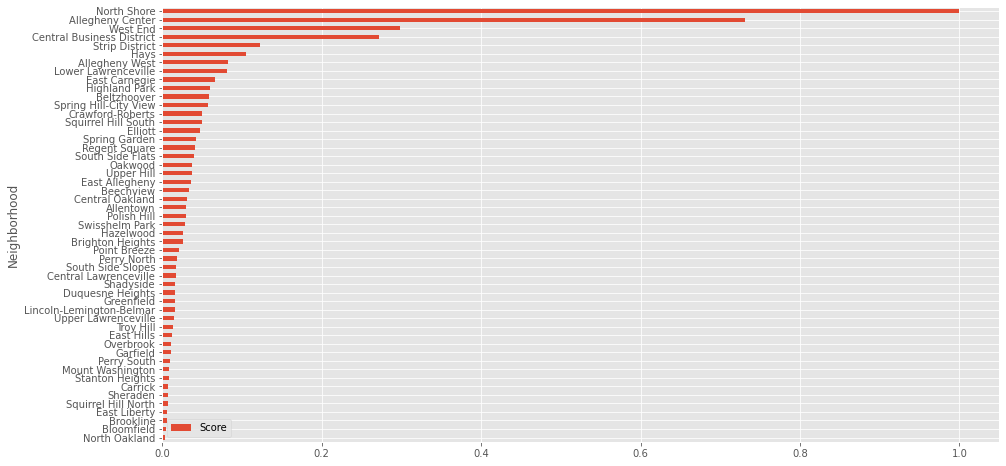

In [8]:
plt.tight_layout()
plt.style.use("ggplot")
plottable_values = combined_data[combined_data["Score"] > 0].sort_values("Score")
plottable_values.plot.barh(x="Neighborhood",y="Score",figsize=(15,8))
plt.savefig("chart.png")

<Figure size 432x288 with 0 Axes>

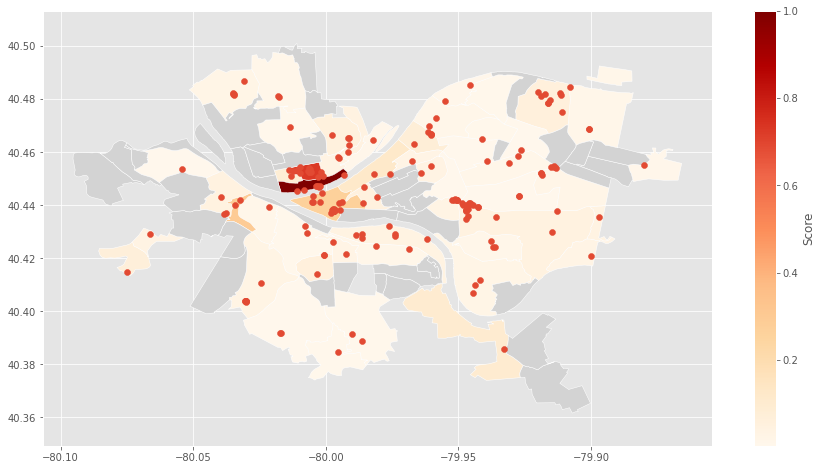

In [9]:
url = "https://data.wprdc.org/dataset/e672f13d-71c4-4a66-8f38-710e75ed80a4/resource/4af8e160-57e9-4ebf-a501-76ca1b42fc99/download/pittsburghpaneighborhoods-.geojson"
neighborhoods_geo = geopandas.read_file(url)
feature_map = neighborhoods_geo.merge(plottable_values, how='left', left_on='hood', right_on='Neighborhood')

gdf = geopandas.GeoDataFrame(public_art_data, geometry=geopandas.points_from_xy(public_art_data["Longitude"], public_art_data["Latitude"]))

plt.tight_layout()
plt.style.use("ggplot")
fig, ax = plt.subplots(1, figsize=(15, 8))
ax.axis('equal')
feature_map.plot(
            ax=ax,
            column='Score', # set the data to be used for coloring
            cmap='OrRd',              # choose a color palette
            edgecolor="white",        # outline the districts in white
            legend=True,              # show the legend
            legend_kwds={'label': "Score"}, # label the legend
            missing_kwds={"color": "lightgrey"} # set districts with no data to gray
            )

gdf.plot(ax=ax)
plt.savefig("map.png")

## Conclusions

### View the top 5 best neighborhoods

In [10]:
plottable_values.sort_values("Score",ascending=False).reset_index()[["Neighborhood","Score"]].head()

,Neighborhood,Score
0,North Shore,1.000000
1,Allegheny Center,0.730707
2,West End,0.298228
3,Central Business District,0.271356
4,Strip District,0.122971
